In [1]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config
from timeit import timeit






3.5579936504364014 TeV


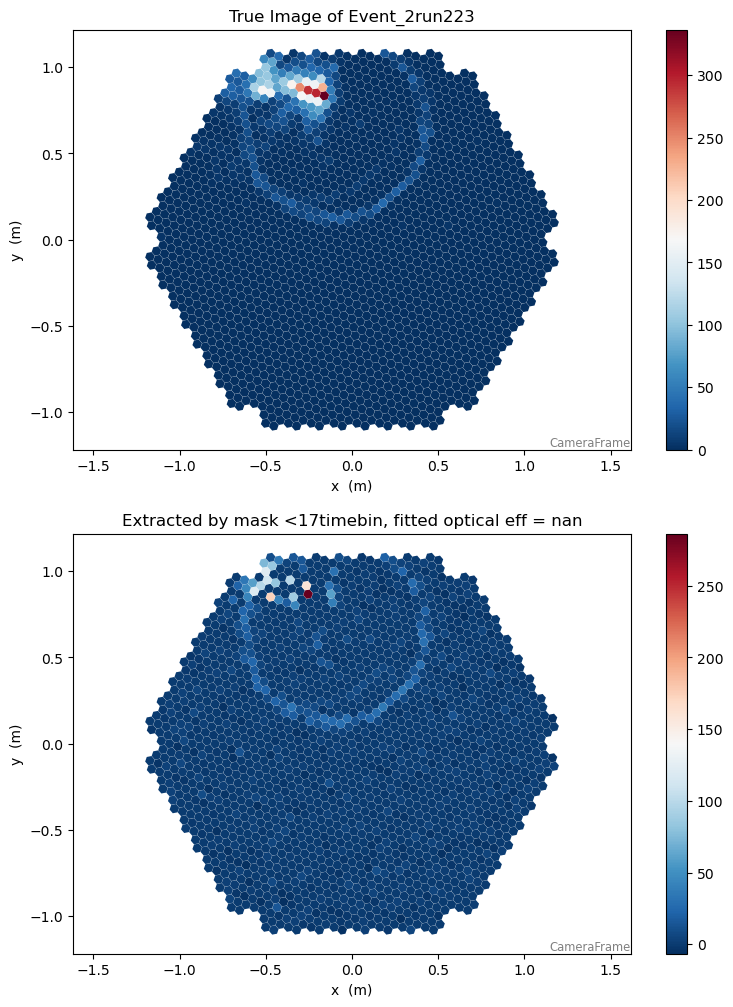

1.3029839992523193 TeV


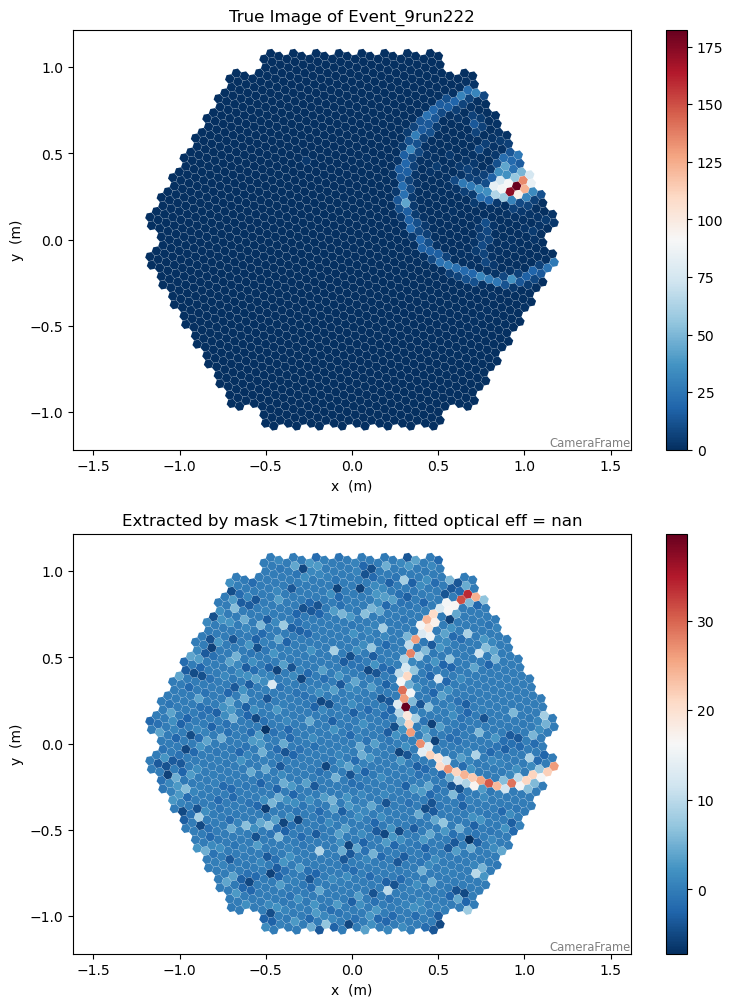

/Users/vdk/mambaforge/envs/cta/lib/python3.11/site-packages/ctapipe/image/pixel_likelihood.py:98: RuntimeWarning: invalid value encountered in log
  neg_log_l = np.log(theta + EPSILON) + (image - prediction) ** 2 / theta


3.5579936504364014 TeV


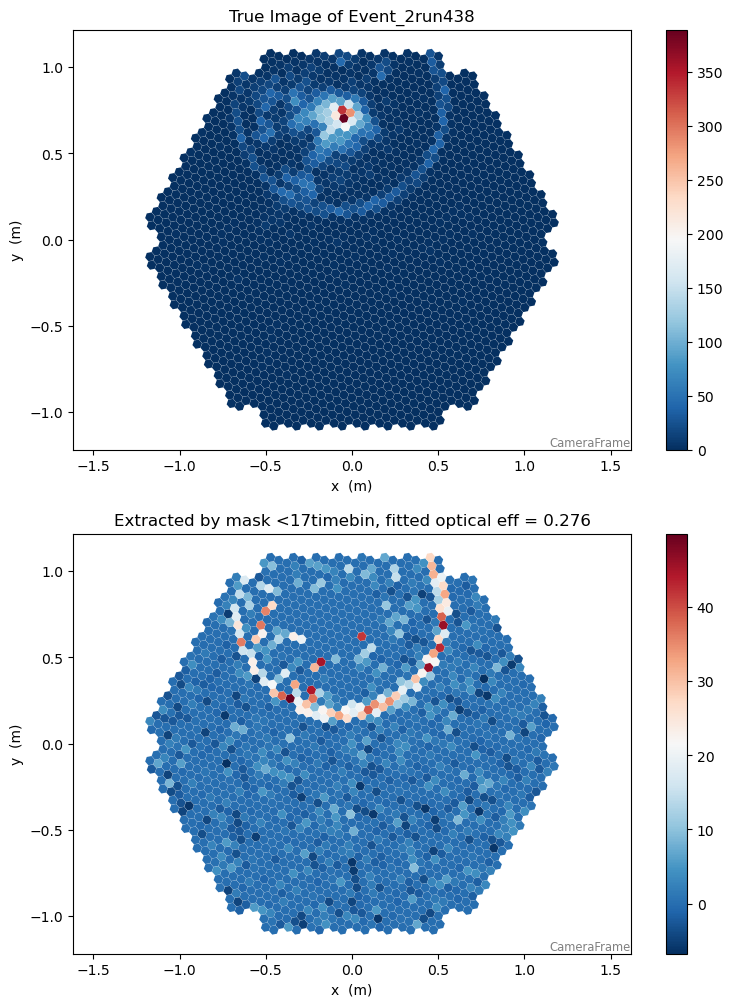

1.6968226432800293 TeV


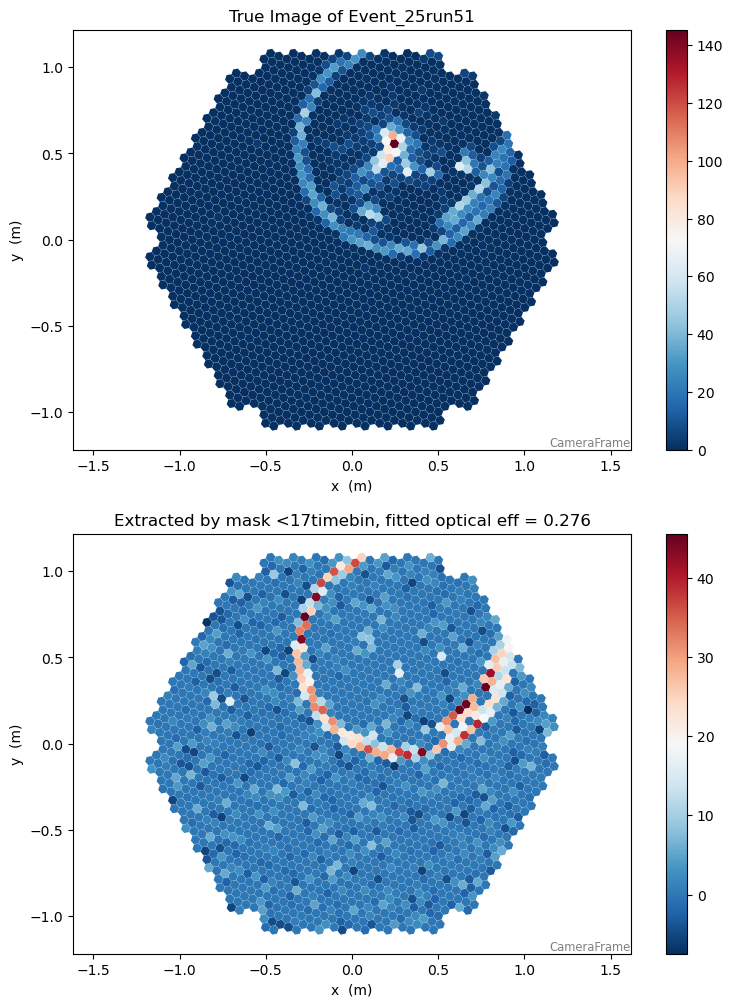

0.2691369950771332 TeV


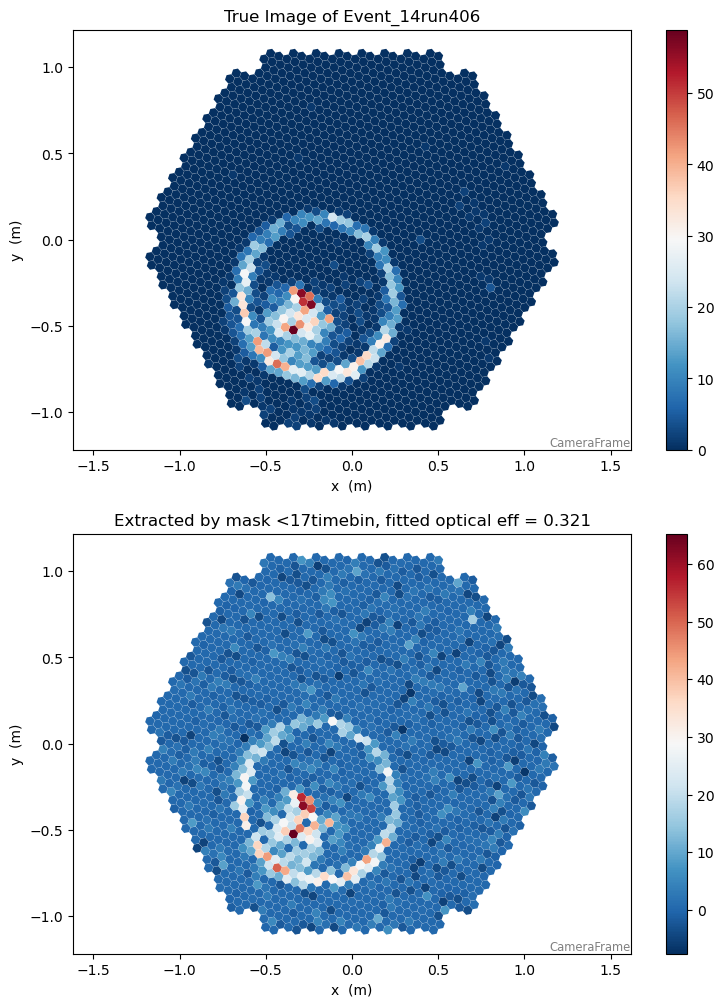

6.007574081420898 TeV


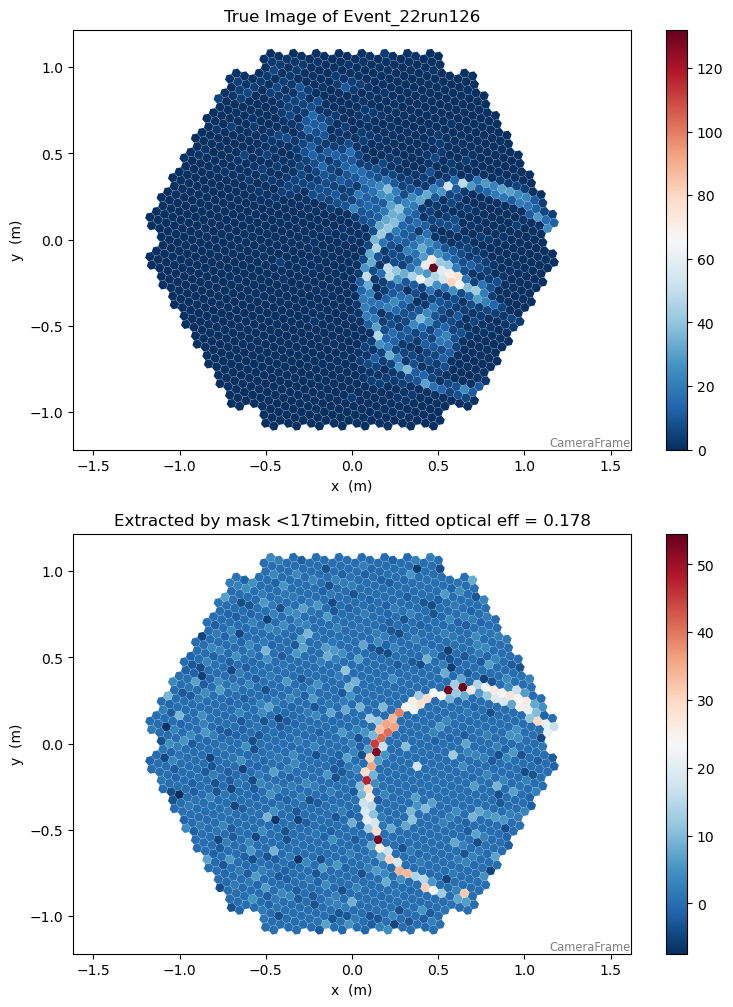

6.007574081420898 TeV


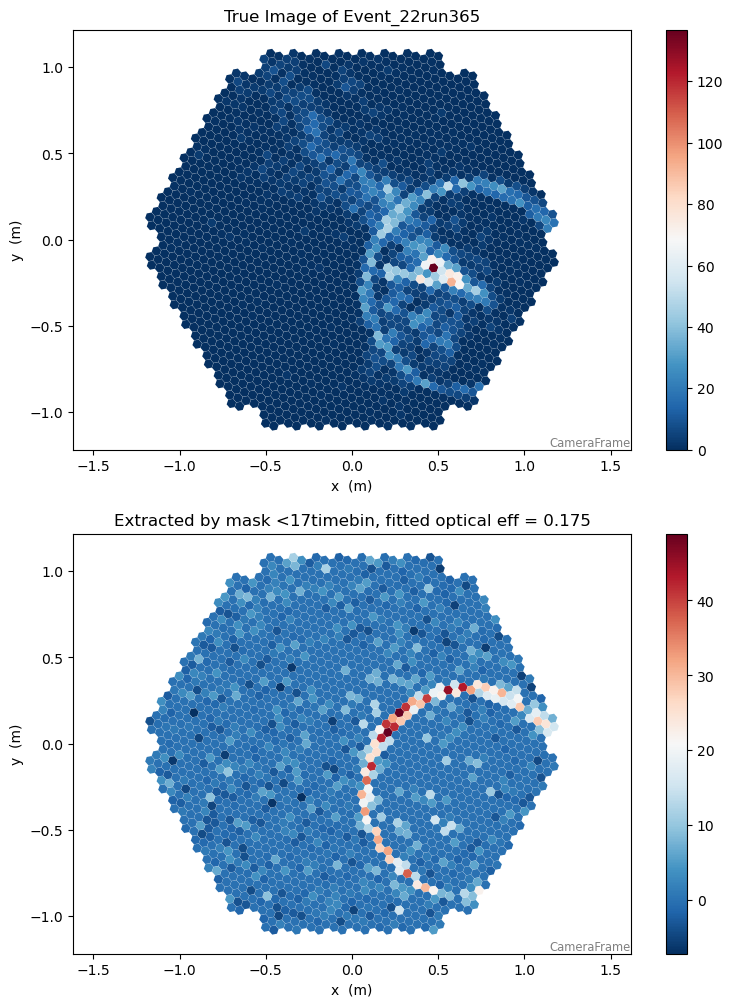

0.4750739634037018 TeV


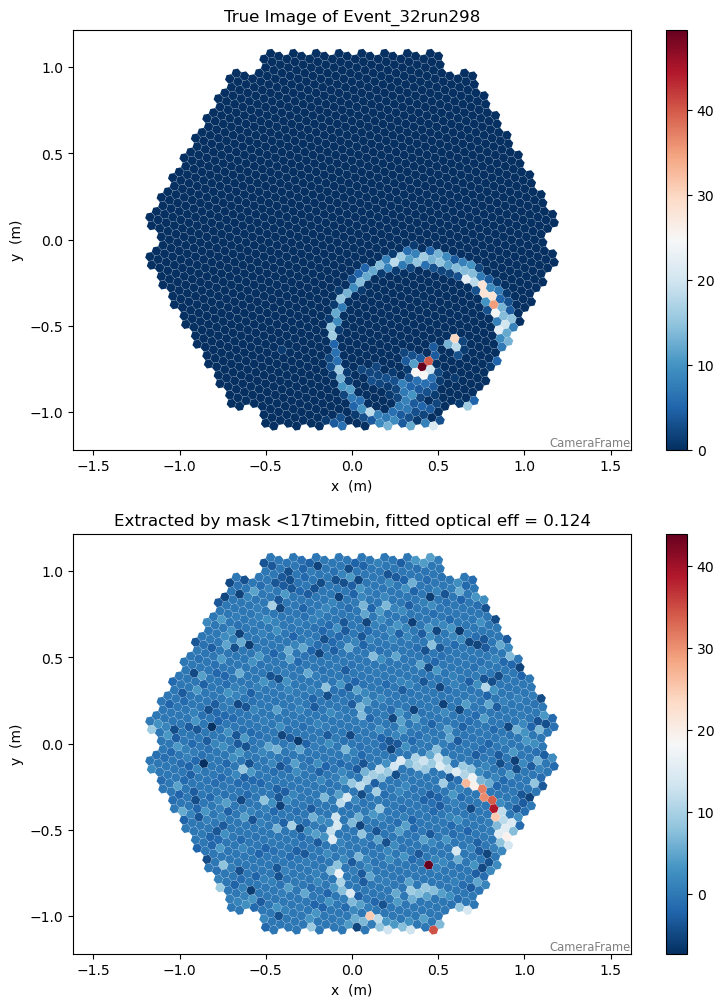

KeyboardInterrupt: 

In [5]:
###
###
### EXTRACT SHOWER FROM IMAGE
###
###
###


#
#
#
#
#
# Main algorihtm to process events with mask to extract ONLY muon ring
#
#
#
#
#

deleted_pixels = []

#2223, 9222, 2438, 25051, 14406, 22126, 22365, 32298, 35219, 8234, 8448, 9404, 9433, 27374, 28328, 28000, 35298
contaminated_runs = [2,9,2,25,14,22,22, 32,35,8,8,9,9,27,28,28,35]
contaminated_events = [223, 222, 438, 51, 406, 126, 365, 298, 219, 234, 448, 404, 433, 374, 328, 0, 298]
tel_numbers = [2, 2,3,1,1,1,1, 3, 2, 1,1,1,3,2,1,1,2]
events = []
working_waves = []


calib_config = Config({"GlobalPeakWindowSum": {"window_width" :7, "window_shift" : 3}})



for i,j in enumerate(contaminated_runs):
    counter = 0
    tel_number = tel_numbers[i]
    filename = f'/Users/vdk/sim_run_folder/output_prod_v12/corsika_theta_28.4_az_182.75_run{j}.simtel.gz'
    source = EventSource(filename, max_events=9000)
    event_iterator = iter(source)
    for k,l in enumerate(event_iterator):
        if k == contaminated_events[i]:
            event = l
            events.append(event)
            break
    # Building appropriate image for this event
    
    
    fig, axes = plt.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [1, 1]}, figsize=(9,12))
    fig.subplots_adjust(hspace=0.2)
    ax = axes[0]
    camgeom = source.subarray.tel[1].camera.geometry
    title= f"True Image of Event_{str(contaminated_runs[i])+'run'+str(contaminated_events[i])}"
    disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True, ax = ax)
    disp.image = event.simulation.tel[tel_number].true_image
    disp.cmap = plt.cm.RdBu_r
    disp.add_colorbar()
    disp.set_limits_percent(95)
    bx = axes[1]
    pixel_mask = []
    time_bin_separation = 17
    
    for k,l in enumerate(event.r0.tel[tel_number].waveform[1]):
        if np.argmax(l) in range(time_bin_separation,40): 
            pixel_mask.append(True)
            counter += 1
        else:
            pixel_mask.append(False)
    working_wave = event.r1.tel[tel_number].waveform.copy()
    for k,l in enumerate(working_wave):
        if pixel_mask[k]:
            #working_wave[k] = np.zeros(40)     
            #working_wave[k] = np.mean(event.r1.tel[tel_number].waveform, axis = 0)
            working_wave[k] = np.array([np.mean(np.mean(event.r1.tel[tel_number].waveform[:,:9], axis = 0)) for i in np.mean(event.r1.tel[tel_number].waveform, axis = 0)])
    working_waves.append(working_wave)
    event.r1.tel[tel_numbers[i]].waveform = working_wave
    
    image_processor = ImageProcessor(source.subarray)
    muon_processor = MuonProcessor(source.subarray)
    calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum", subarray = source.subarray, config = calib_config)
    calib(event)
    image_processor(event)
    muon_processor(event)
    deleted_pixels.append(counter)
    #opt_effi = []
    #if not np.isnan(event.muon.tel[tel_numbers[i]].efficiency.optical_efficiency):
    #opt_effi.append(event.muon.tel[tel_numbers[i]])
    camgeom = source.subarray.tel[1].camera.geometry
    title= f"Extracted by mask <{time_bin_separation}timebin, fitted optical eff = {round(event.muon.tel[tel_number].efficiency.optical_efficiency, 3)}"
    disp = CameraDisplay(camgeom,title=title, norm = 'lin', autoscale = False, allow_pick = True, ax=bx)
    disp.image = working_wave.sum(axis=1)
    disp.cmap = plt.cm.RdBu_r
    disp.add_colorbar()
    disp.set_limits_percent(95)
    print(event.simulation.shower.energy)
    plt.show()
    #plt.savefig(f"/Users/vdk/ImagePurgatorium/ProcessedEvents<{time_bin_separation}timebinMEAN_event{str(contaminated_runs[i])+str(contaminated_events[i])}")
    
plt.close()


print("SHOWER PIXELS = ", counter)
print("RING PIXELS = ", len(event.r1.tel[tel_numbers[i]].waveform)-counter)

In [ ]:
np.mean(np.mean(event.r1.tel[tel_number].waveform[:,:8], axis = 0))

In [ ]:
np.array([np.mean(np.mean(event.r1.tel[tel_number].waveform[:,:8], axis = 0)) for i in np.mean(event.r1.tel[tel_number].waveform, axis = 0)]).shape